In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import http.client
import json
import os

In [2]:
with open('dataset/fb_transfers.csv') as csvfile:
    totalCount = 0
    headerRow = []
    componentRows = []
    readCSV = csv.reader(csvfile, delimiter=',')
    myPlayerDict = {}
    for row in readCSV:
        myTempRow = []
        if totalCount==0:
            for column in row:
                headerRow.append(column)
        else:
            for column in row:
                myTempRow.append(column)
            componentRows.append(myTempRow)
        totalCount += 1

## Testing total count and data captured

In [3]:
headerRow[0] = 'PLAYER'
index = 0
for element in headerRow:
    headerRow[index] = (element.strip()).upper()
    index += 1

In [4]:
finalData = []
for row in componentRows:
    index = 0
    saleDict = {}
    for element in headerRow:
        saleDict[element] = row[index].upper()
        index += 1
    finalData.append(saleDict)

In [5]:
def filterTransactions(dataPassed, transaction):
    salesOnly = []
    for row in dataPassed:
        if row['PRICE DESCRIPTION'] == transaction:
            salesOnly.append(row)
    return salesOnly

## Filtered Sale Data is now availible

In [6]:
sales = filterTransactions(finalData, 'SOLD')
loans = filterTransactions(finalData, 'LOAN')
frees = filterTransactions(finalData, 'FREE')
undisclosed = filterTransactions(finalData, 'UNDISCLOSED')

Text(0.5, 1.0, 'Total Player Transfers: 2017 - 2018')

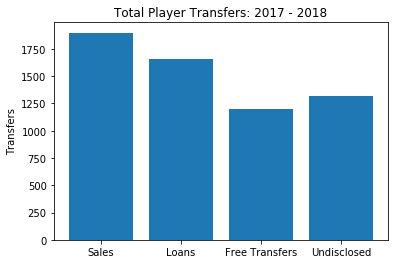

In [7]:
objects = ('Sales', 'Loans', 'Free Transfers', 'Undisclosed')
y_pos = np.arange(len(objects))
transactions = [len(sales), len(loans), len(frees), len(undisclosed)]
 
plt.bar(y_pos, transactions, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Transfers')
plt.title('Total Player Transfers: 2017 - 2018')

## Function definitions to get and sanitise data from teams of the top 9 competitons

In [8]:
def fetchKey():
    path = './dataset/myAPIKey.txt'
    apikey_file = open(path,'r')
    return apikey_file.read()

In [9]:
def clearData(path):
    os.remove(path)

In [10]:
def fetchTeamData():
    myDataDict = {}
    connection = http.client.HTTPConnection('api.football-data.org')
    myAPIKey = fetchKey()
    headers = { 'X-Auth-Token': myAPIKey }
    counter = 0
    masterTeamSet = {}
    wantedCompetitions = [2021, 2014, 2015, 2002, 2017, 2001, 2019, 2003]
    competitionTitles = ["EPL", "LaLiga", "Ligue1", "Bundesliga", "Primera_Liga", "UCL", "Serie_A", "Eredivisie"]
    for competition in wantedCompetitions:
        url = '/v2/competitions/{}/teams'.format(competition)
        connection.request('GET', url, None, headers )
        response = json.loads(connection.getresponse().read().decode())
        masterTeamSet[competitionTitles[counter]] = response
        counter += 1
    return masterTeamSet

In [11]:
def getTeamList(myData):
    for key,value in myData.items():
        for key2,value2 in value.items():
            if(key2=='teams'):
                myData[key] = value2
    return myData

In [12]:
def cleanTeamList(myData):
    for key,value in myData.items():
        league = []
        for element in value:
            freshElement = {}
            if type(element) is dict:
                freshElement['name'] = element['name']
                freshElement['shortName'] = element['shortName']
                freshElement['venue'] = element['venue']
                league.append(freshElement)
        myData[key]=league
    return myData

In [13]:
def getFreshData():
    myData = fetchTeamData()
    teamList = getTeamList(myData)    
    cleanList = cleanTeamList(teamList)
    return cleanList

## Functions to parse this data, and scrape for stadium capacities

In [14]:
def filterCapacityString(myString):
    instances = 0
    num = ""
    for c in myString:
        if c.isnumeric() or c==',':
            instances += 1
            if c != ',':
                num += c
        else:
            if instances != 0:
                return num
    return num

In [15]:
def getSERPKey():
    path = './dataset/mySERPKey.txt'
    apikey_file = open(path,'r')
    return apikey_file.read()

In [16]:
from lib.google_search_results import GoogleSearchResults
def getCapacity(stadiumName):
    myVal = '/000/'
    mySERPKey = getSERPKey()
    try:
        queryTitle = stadiumName + " capacity"
    except:
        print("Exception, going to N/A")
        return myVal
    query = GoogleSearchResults({"q": queryTitle, "serp_api_key": mySERPKey})
    dictionary_results = query.get_dictionary()
    resultDict = dictionary_results['organic_results'][0]
    for key,value in resultDict.items():
        if key=='rich_snippet':
            target = value['bottom']
            try:
                myVal = (target['detected_extensions']['capacity'])
            except:
                myVal = (filterCapacityString(target['extensions'][0]))
    return str(myVal)

In [17]:
def clonePlusCapacity(valueDict):
    newDict = {}
    stadiumName = valueDict['venue']
    newDict['name'] = valueDict['name']
    newDict['shortName'] = valueDict['shortName']
    newDict['venue'] = valueDict['venue']
    myCapacity = getCapacity(stadiumName)
    newDict['venue_capacity'] = myCapacity
    return newDict

In [18]:
def addCapacities(cleanList):
    index = 0
    for key,values in cleanList.items():
        newValues = []
        for value in values:
            newValues.append(clonePlusCapacity(value))
        cleanList[key] = newValues
    return cleanList

## Actually get the data, sanitise it, and store it for reuse- since it changes only every year

In [19]:
cleanPath = './dataset/cleanMaster.npy'
cleanList = {}
#clearData(cleanPath)
try:
    cleanList = np.load(cleanPath).item()
except:
    print("No old data, fetching and cleaning new set...")
    cleanList = getFreshData()
    cleanList = addCapacities(cleanList)
    np.save(cleanPath, cleanList)

In [20]:
def getTeamCount(cleanList):
    counter = 0
    for key,values in cleanList.items():
        for value in values:
            counter += 1
    return counter

In [21]:
getTeamCount(cleanList) #To verify the count, should be 213

213

In [22]:
def filterLeague(myKey):
    for key,value in cleanList.items():
        if(key==myKey):
            return value

In [23]:
leagueNames = ["EPL", "LaLiga", "Ligue1", "Bundesliga", "Primera_Liga", "UCL", "Serie_A", "Eredivisie"]
teamCount = []
for title in leagueNames:
    teamCount.append(filterLeague(title))

Text(0.5, 1.0, 'Breakup of teams in each competiton')

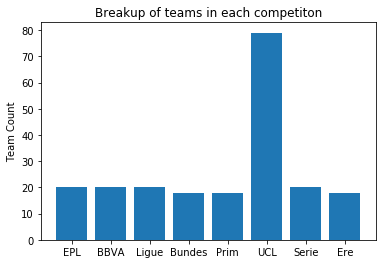

In [24]:
leagues = ["EPL", "BBVA", "Ligue", "Bundes", "Prim", "UCL", "Serie", "Ere"]
objects = (leagues[0],leagues[1],leagues[2],leagues[3],leagues[4],leagues[5],leagues[6],leagues[7],)
y_pos = np.arange(len(objects))
teamCounts = [len(teamCount[0]),len(teamCount[1]),len(teamCount[2]),len(teamCount[3]),len(teamCount[4]),len(teamCount[5]),len(teamCount[6]),len(teamCount[7]),]
 
plt.bar(y_pos, teamCounts, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Team Count')
plt.title('Breakup of teams in each competiton')

## First, consider the EPL - filter EPL transfers and their corresponding teams, to build a starting sample training set

In [25]:
cleanEPL = cleanList['EPL']

In [26]:
names = []
shortNames = []
for element in cleanEPL:
    names.append(element['name'])
    shortNames.append(element['shortName'])

In [27]:
eplSales= []
for sale in finalData:
    if sale['LEAGUE'] == "EPL":
        eplSales.append(sale)

In [28]:
eplSales = filterTransactions(eplSales, 'SOLD')